# Mowing Like a Salesperson Travels

In [1]:
import gurobi as g
import numpy as np

These classes are used for creating the map of a yard. T is for a standard tile and B is for a "blocked" tile. Blocked tiles are for areas in a yard one can't mow like trees, bushes, houses, etc.

I is used as a sort of identity service. It generates unique ids when asked. The tiles make use of this to id themselves.

In [2]:
class I:
    def __init__(self):
        self._counter = -1
    def next(self):
        self._counter += 1
        return self._counter

class T:
    def __init__(self, incrementor):
        self._connected_tiles = []
        self._id = incrementor.next()
    def connects_to(self, to_tile):
        self._connected_tiles.append(to_tile)
    def get_both_directed_edges(self):
        return [(self._id, to_tile._id) for to_tile in self._connected_tiles]
    def is_blocked(self):
        return False
class B:
    def __init__(self, incrementor):
        self._id = incrementor.next()
    def connects_to(self, to_tile):
        pass
    def get_both_directed_edges(self):
        return []
    def is_blocked(self):
        return True

These are scenarios I created to play with this program. These can be used further down the notebook.

In [3]:
def generate_house_tiles():
    i = I()
    # Create tiles for my yard as a grid
    tiles = []
    # Map grid locations to an array
    locations = []
    for row_index in range(44):
        row = []
        for column_index in range(26):
            if 0 <= row_index and row_index <= 5 and \
               0 <= column_index and column_index <= 7:
                row.append(B(i))
            elif 6 <= row_index and row_index <= 10 and \
                 0 <= column_index and column_index <= 5:
                row.append(B(i))
            elif 0 <= row_index and row_index <= 2 and \
                 19 <= column_index and column_index <= 25:
                row.append(B(i))
            elif 3 <= row_index and row_index <= 4 and \
                 20 <= column_index and column_index <= 25:
                row.append(B(i))
            elif 5 <= row_index and row_index <= 5 and \
                 23 <= column_index and column_index <= 25:
                row.append(B(i))
            elif 6 <= row_index and row_index <= 7 and \
                 24 <= column_index and column_index <= 25:
                row.append(B(i))
            elif 8 <= row_index and row_index <= 9 and \
                 25 <= column_index and column_index <= 25:
                row.append(B(i))
            elif 8 <= row_index and row_index <= 10 and \
                 10 <= column_index and column_index <= 12:
                row.append(B(i))
            elif 16 <= row_index and row_index <= 17 and \
                 1 <= column_index and column_index <= 2:
                row.append(B(i))
            elif 13 <= row_index and row_index <= 15 and \
                 6 <= column_index and column_index <= 16:
                row.append(B(i))
            elif 16 <= row_index and row_index <= 17 and \
                 6 <= column_index and column_index <= 23:
                row.append(B(i))
            elif 18 <= row_index and row_index <= 23 and \
                 5 <= column_index and column_index <= 23:
                row.append(B(i))
            elif 24 <= row_index and row_index <= 31 and \
                 5 <= column_index and column_index <= 25:
                row.append(B(i))
            elif 32 <= row_index and row_index <= 43 and \
                 21 <= column_index and column_index <= 25:
                row.append(B(i))
            elif 34 <= row_index and row_index <= 35 and \
                 17 <= column_index and column_index <= 18:
                row.append(B(i))
            elif 41 <= row_index and row_index <= 42 and \
                 5 <= column_index and column_index <= 6:
                row.append(B(i))
            elif 41 <= row_index and row_index <= 42 and \
                 9 <= column_index and column_index <= 10:
                row.append(B(i))
            elif 41 <= row_index and row_index <= 42 and \
                 13 <= column_index and column_index <= 14:
                row.append(B(i))
            elif 41 <= row_index and row_index <= 42 and \
                 17 <= column_index and column_index <= 18:
                row.append(B(i))
            else:
                row.append(T(i))
            locations.append((column_index, row_index))
        tiles.append(row)

    # Tiles mapped onto linear list
    flat_tiles = [x for row in tiles for x in row] #AKA tile_list
    return tiles, locations, flat_tiles

def generate_demo_tiles():
    i = I()
    # Create tiles for my yard as a grid
    tiles = []
    # Map grid locations to an array
    locations = []
    for row_index in range(15):
        row = []
        for column_index in range(15):
            if 4 <= row_index and row_index <= 8 and \
               2 <= column_index and column_index <= 4:
                row.append(B(i))
            elif 5 <= row_index and row_index <= 6 and \
                 5 <= column_index and column_index <= 9:
                row.append(B(i))
            elif 2 <= row_index and row_index <= 2 and \
                 6 <= column_index and column_index <= 7:
                row.append(B(i))
            elif 7 <= row_index and row_index <= 8 and \
                 8 <= column_index and column_index <= 9:
                row.append(B(i))
            else:
                row.append(T(i))
            locations.append((column_index, row_index))
        tiles.append(row)

    # Tiles mapped onto linear list
    flat_tiles = [x for row in tiles for x in row] #AKA tile_list
    return tiles, locations, flat_tiles

These functions do the hard stuff. They interpret the tile layout and create a set of edges and turns for the unblocked locations.

In [4]:
def enumerate_edge_turns(edges):
    edge_turns = set()
    for left_edge_indexes in edges:
        left_edge = tuple(locations[x] for x in left_edge_indexes)
        for right_edge_indexes in [x for x in edges if x != left_edge_indexes and left_edge_indexes[1] == x[0]]:
            right_edge = tuple(locations[x] for x in right_edge_indexes)
            if is_turn(left_edge, right_edge):
                edge_turns.add(((locations.index(left_edge[0]), locations.index(left_edge[1])), (locations.index(right_edge[0]), locations.index(right_edge[1]))))
    return edge_turns

def is_turn(edge1, edge2):
    assert edge1[1] == edge2[0], 'Edge1 doesn\'t connect to edge2! {0}'.format(edge1,edge2)
    x, y = list(zip(*[edge1[0],edge1[1],edge2[1]]))
    return not (x[0] == x[1] == x[2]) and not (y[0] == y[1] == y[2])

def generate_edges_for(tiles):
    for row_index in range(len(tiles)):
        for col_index in range(len(tiles[0])):
            from_tile = tiles[row_index][col_index]
            if from_tile.is_blocked():
                continue
            for row_offset in [-1,0,1]:
                for col_offset in [-1,0,1]:
                    offset_row_index = row_index + row_offset
                    offset_col_index = col_index + col_offset

                    if offset_row_index < 0 or offset_row_index > len(tiles)-1:
                        continue
                    if offset_col_index < 0 or offset_col_index > len(tiles[0])-1:
                        continue
                    if row_offset == 0 and col_offset == 0:
                        continue
                    if np.abs(row_offset) + np.abs(col_offset) == 2:
                        continue
                    to_tile = tiles[offset_row_index][offset_col_index]
                    if not to_tile.is_blocked():
                        from_tile.connects_to(to_tile)

    edges = [from_tile.get_both_directed_edges() for rows in tiles for from_tile in rows]
    edges = [pair for edge_list in edges for pair in edge_list]
    edge_turns = enumerate_edge_turns(edges)
    return edges, edge_turns

This code can evaluate a proposed solution and find cycles that are added as constraints.

In [5]:
def _find_cycles(solution_edges):
    cycles = []
    shortest_cycle = None
    while len(solution_edges) > 0:
        cycle=[]
        edge = solution_edges[0]
        first_node = edge[0]
        next_node = first_node
        nodes_to_remove = set()
        while True:
            next_node_index = [from_node for from_node, to_node in solution_edges].index(next_node)
            next_edge = solution_edges[next_node_index]
            next_node = next_edge[1]
            cycle.append(tuple([element for tuple_ in next_edge for element in tuple_]))
            nodes_to_remove.add(next_node_index)
            if next_node == first_node:
                print('Cycle length: ', len(cycle))
                break
        solution_edges = [x for i, x in enumerate(solution_edges) if i not in nodes_to_remove]
        cycles.append(cycle)
        if shortest_cycle is None or len(cycle) < len(shortest_cycle):
            shortest_cycle = cycle
    return shortest_cycle, len(cycles), cycles

# This method just enables debugging.
def find_cycles(location_edges):
    # We round the solution because floating point error is REAL!!
    solution_edges = [(locations[xy1], locations[xy2]) for xy1, xy2 in location_edges if round(location_edges[xy1, xy2].X) == 1]
    print('About to find cycles!')
    return _find_cycles(solution_edges)

def to_loc(edge):
    location_index_1 = locations.index((edge[0], edge[1]))
    location_index_2 = locations.index((edge[2], edge[3]))
    return (location_index_1, location_index_2)

This code is used for displaying the map and the solutions. Basically just works by plotting a line segment for every activated edge. Turns aren't necessary since the edges themselves imply turns.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_tsp_solution(flat_tiles, location_edges=[], row_count=44, col_count=26, solution_exists=True):
    plt.figure(figsize=(col_count/3,row_count/3))
    plt.suptitle('TSP Solution to Mowing Lawn ({0} units x {1} units)'.format(col_count, row_count))
    plt.title('Red things are blocking objects')
    for column_index in range(col_count+1):
        plt.plot([-0.5+column_index, -0.5+column_index], [0-0.5, row_count+0.5-1], color='g', linestyle=':', linewidth=1);
    for row_index in range(row_count+1):
        plt.plot([0-0.5, (col_count-1)+0.5], [-0.5+row_index, -0.5+row_index], color='g', linestyle=':', linewidth=1);
    
    # If we don't have edges to plot don't try so 
    # we can still just plot the tiles without paths
    if solution_exists:
        for edge in location_edges:
            if round(location_edges[edge].X) == 1:
                xy1, xy2 = edge
                y1 = locations[xy1][1]
                x1 = locations[xy1][0]

                y2 = locations[xy2][1]
                x2 = locations[xy2][0]

                #print((x1, y1), (x2,y2))
                plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2);
    
    # Plot blocked points
    for index, tile in enumerate(flat_tiles):
        if tile.is_blocked():
            x,y = locations[index]
            plt.scatter(x,y,c='r',marker='s',s=160);
    plt.show()

# The Mathematical Model


Variables:

$ L = (x,y)\ locations\ of\ all\ tiles$

$ E = (l_1, l_2) \in L $

$ T = (e_1, e_2)\ where\ e_1,e_2 \in E\ and\ F_T(e_1, e_2)$

$F_T(e_1, e_2) = \begin{cases} 
  1 & if\ edges\ form\ a\ turn\\
  0 & otherwise
\end{cases}$

$F_A(l_1, l_2) = \begin{cases} 
  1 & if\ locations\ are\ adjacent\\
  0 & otherwise
\end{cases}$

$x^T_{ij} = \begin{cases} 
  1 & if\ turn\ is\ used\\
  0 & otherwise
\end{cases}
where\ (i,j) \in T
$

$x^E_{ij} = \begin{cases} 
  1 & if\ edge\ is\ used\\
  0 & otherwise
\end{cases} where (i,j) \in L $

$ \sum_{i \in L} x^E_{ij} = F_A(i,j),\ \forall\ j \in L$ Each location is entered via exactly one edge

$ \sum_{j \in L} x^E_{ij} = F_A(i,j),\ \forall\ i \in L $ Each location is exited via exactly one edge

$ x^E_{ij} + x^E_{ji} <= 1,\ \forall\ i,j \in L $ A location can't loop to itself.

$-1 + x^E_i + x^E_j <= 2x^T_{ij} <= x^E_i + x^E_j\ \forall i,j \in T $

# The Coded Model

The top of the picture is the front of my house.


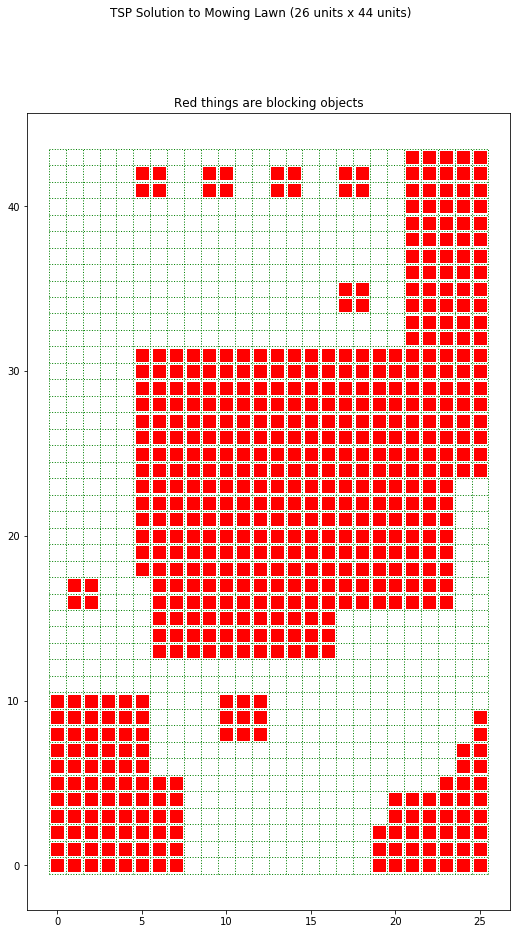

In [7]:
# For generating tiles to optimize mowing my personal yard
tiles, locations, flat_tiles = generate_house_tiles()
# This one generates a fairly solveable problem for testing.
#tiles, locations, flat_tiles = generate_demo_tiles()

# Create what I'll use for my variables
edges, edge_turns = generate_edges_for(tiles)

# Let's see what our scenario looks like without a path
print('The top of the picture is the front of my house.')
plot_tsp_solution(flat_tiles, solution_exists=False)

Create the model and define the variables we'll use. Here we create variables for every valid edge and every possible turn from each of those edges.

In [8]:
# The actual model definition
m = g.Model('tsp')
location_edges  = m.addVars(edges,  name="location_edges",  vtype=g.GRB.BINARY)
location_edge_turns  = m.addVars(edge_turns,  name="location_edge_turns",  vtype=g.GRB.BINARY)

Academic license - for non-commercial use only


For every location that isn't "blocked" (blocked meaning it has a red square in the picture above) constrain the solution such that exactly one edge leads into the location and one leads out from it.

In [9]:
for location in range(len(tiles)*len(tiles[0])):
    if not flat_tiles[location].is_blocked():
        m.addConstr(location_edges.sum(location, '*') == 1)
        m.addConstr(location_edges.sum('*', location) == 1)

Make sure no location has an edge that leads to itself.

In [10]:
for edge in location_edges:
    m.addConstr(location_edges[edge] + location_edges[(edge[1], edge[0])] <= 1)

Next add the constraints that will set the turn variables enabling us to count how many turns are made.

In [11]:
for edge_turn in edge_turns:
    # These two constraints work to fix the turn variables
    # And keep them in sync with the edges
    # -1/2 + 1/2 * (edge_1 + edge_2) <= turn_12
    # turn_12 <= 1/2 * (edge_1 + edge_2)
    m.addConstr(-1 + location_edges[edge_turn[0]] + location_edges[edge_turn[1]] <= location_edge_turns[edge_turn[0], edge_turn[1]])
    m.addConstr(location_edge_turns[edge_turn[0], edge_turn[1]] <= location_edges[edge_turn[0]] + location_edges[edge_turn[1]])

Our objective value is most important! Here I set the objective value to just minimize the number of turns that are made when mowing my lawn.

In [12]:
objective_value = g.LinExpr()
objective_value += sum([location_edge_turns[turn] for turn in location_edge_turns])
m.setObjective(objective_value, g.GRB.MINIMIZE)

Next, we run the model. Note that it is ran and then we enter a while loop to keep running it as long as there are more than two cycles. Why two and not one? If we find a solution with two cycles I'm willing to call it "good enough".

Optimize a model with 10538 rows, 5722 columns and 30200 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1600 rows and 314 columns
Presolve time: 0.06s
Presolved: 8938 rows, 5408 columns, 26622 nonzeros
Variable types: 0 continuous, 5408 integer (5408 binary)
Found heuristic solution: objective 174.0000000

Root relaxation: objective 2.300000e+01, 2440 iterations, 0.15 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   23.00000    0 1263  174.00000   23.00000  86.8%     -    0s
H    0     0                     166.0000000   23.00000  86.1%     -    0s
     0     0   30.50000    0 1439  166.00000   30.50000  81.6%     -    1s
     0     0   30.50000    0 1425  166.00000   3

     0     0   99.30242    0 1924  152.00000   99.30242  34.7%     -   18s
     0     0   99.32658    0 1937  152.00000   99.32658  34.7%     -   18s
     0     0  100.47088    0 1919  152.00000  100.47088  33.9%     -   18s
     0     0  101.13045    0 1917  152.00000  101.13045  33.5%     -   18s
     0     0  101.20101    0 1953  152.00000  101.20101  33.4%     -   19s
     0     0  101.21691    0 1989  152.00000  101.21691  33.4%     -   19s
     0     0  102.19470    0 1923  152.00000  102.19470  32.8%     -   19s
     0     0  102.46491    0 1938  152.00000  102.46491  32.6%     -   19s
     0     0  102.56168    0 1928  152.00000  102.56168  32.5%     -   19s
     0     0  102.56965    0 1954  152.00000  102.56965  32.5%     -   19s
     0     0  103.13387    0 1937  152.00000  103.13387  32.1%     -   19s
     0     0  103.30339    0 1904  152.00000  103.30339  32.0%     -   20s
     0     0  103.39798    0 1956  152.00000  103.39798  32.0%     -   20s
     0     0  103.44224  

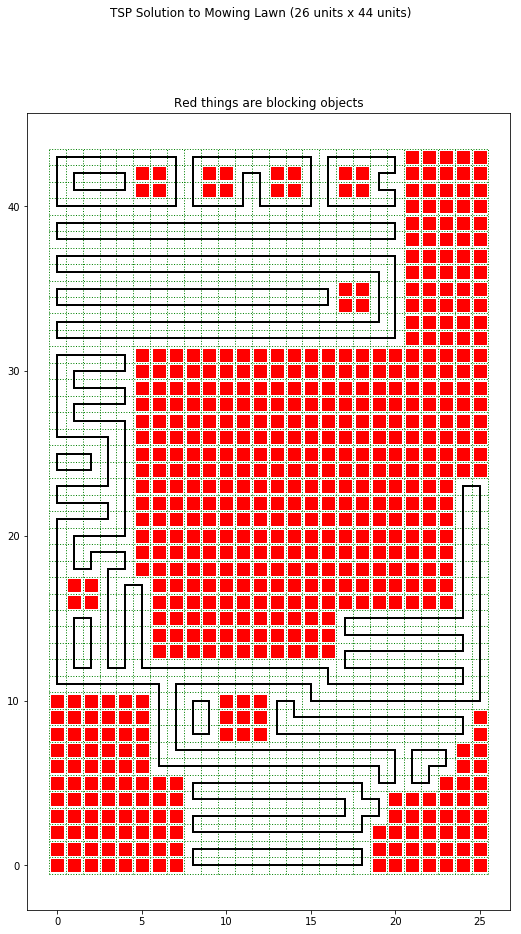

About to find cycles!
Cycle length:  22
Cycle length:  46
Cycle length:  226
Cycle length:  8
Cycle length:  6
Cycle length:  26
Cycle length:  8
Cycle length:  6
Cycle length:  88
Cycle length:  34
Cycle length:  42
Cycle length:  20
Cycle length:  24
Cycle length:  16
Cycle length:  8
Optimize a model with 10553 rows, 5722 columns and 30780 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R10538 by 1.000000000

Presolve removed 1600 rows and 313 columns
Presolve time: 0.08s
Presolved: 8953 rows, 5409 columns, 27147 nonzeros
Variable types: 0 continuous, 5409 integer (5409 binary)
Found heuristic solution: objective 200.0000000

Root relaxation: objective 2.300000e+01, 2392 iterations, 0.19 seconds

    Nodes    |    Current Node 

     0     0  102.68592    0 1918  174.00000  102.68592  41.0%     -   18s
     0     0  102.78123    0 1948  174.00000  102.78123  40.9%     -   18s
     0     0  102.78639    0 1960  174.00000  102.78639  40.9%     -   18s
     0     0  103.66672    0 1944  174.00000  103.66672  40.4%     -   19s
     0     0  103.73871    0 1952  174.00000  103.73871  40.4%     -   19s
     0     0  103.74220    0 1954  174.00000  103.74220  40.4%     -   19s
     0     0  104.69992    0 1890  174.00000  104.69992  39.8%     -   19s
     0     0  104.83856    0 1900  174.00000  104.83856  39.7%     -   20s
     0     0  104.93317    0 1924  174.00000  104.93317  39.7%     -   20s
     0     0  104.98126    0 1924  174.00000  104.98126  39.7%     -   20s
     0     0  104.99436    0 1940  174.00000  104.99436  39.7%     -   20s
     0     0  105.30971    0 1890  174.00000  105.30971  39.5%     -   21s
     0     0  105.43358    0 1876  174.00000  105.43358  39.4%     -   21s
     0     0  105.45255  

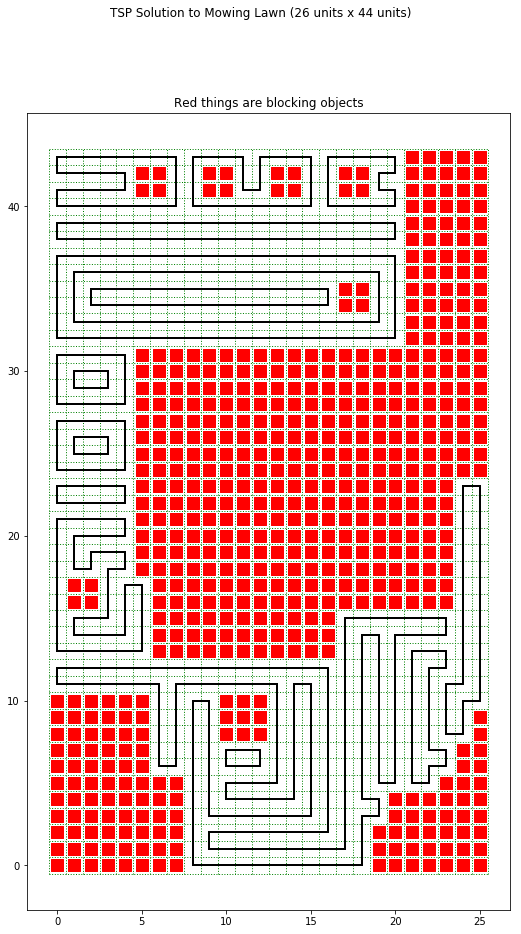

About to find cycles!
Cycle length:  190
Cycle length:  22
Cycle length:  6
Cycle length:  34
Cycle length:  46
Cycle length:  10
Cycle length:  14
Cycle length:  6
Cycle length:  14
Cycle length:  6
Cycle length:  50
Cycle length:  42
Cycle length:  30
Cycle length:  42
Cycle length:  28
Cycle length:  24
Cycle length:  16
Optimize a model with 10570 rows, 5722 columns and 31360 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R10553 by 1.000000000

Presolve removed 1600 rows and 314 columns
Presolve time: 0.08s
Presolved: 8970 rows, 5408 columns, 27670 nonzeros
Variable types: 0 continuous, 5408 integer (5408 binary)
Found heuristic solution: objective 180.0000000

Root relaxation: objective 2.300000e+01, 2530 iterations, 0.18 se

     0     0   99.76675    0 1934  160.00000   99.76675  37.6%     -   18s
     0     0   99.78957    0 1947  160.00000   99.78957  37.6%     -   18s
     0     0  100.95113    0 1887  160.00000  100.95113  36.9%     -   18s
     0     0  101.15059    0 1929  160.00000  101.15059  36.8%     -   18s
     0     0  101.16876    0 1940  160.00000  101.16876  36.8%     -   18s
     0     0  101.40600    0 1925  160.00000  101.40600  36.6%     -   18s
     0     0  101.51345    0 1965  160.00000  101.51345  36.6%     -   19s
     0     0  101.52463    0 1958  160.00000  101.52463  36.5%     -   19s
     0     0  102.05877    0 1941  160.00000  102.05877  36.2%     -   19s
     0     0  102.12860    0 1951  160.00000  102.12860  36.2%     -   19s
     0     0  102.12950    0 1952  160.00000  102.12950  36.2%     -   19s
     0     0  102.56367    0 1876  160.00000  102.56367  35.9%     -   19s
     0     0  102.61273    0 1953  160.00000  102.61273  35.9%     -   19s
     0     0  102.61308  

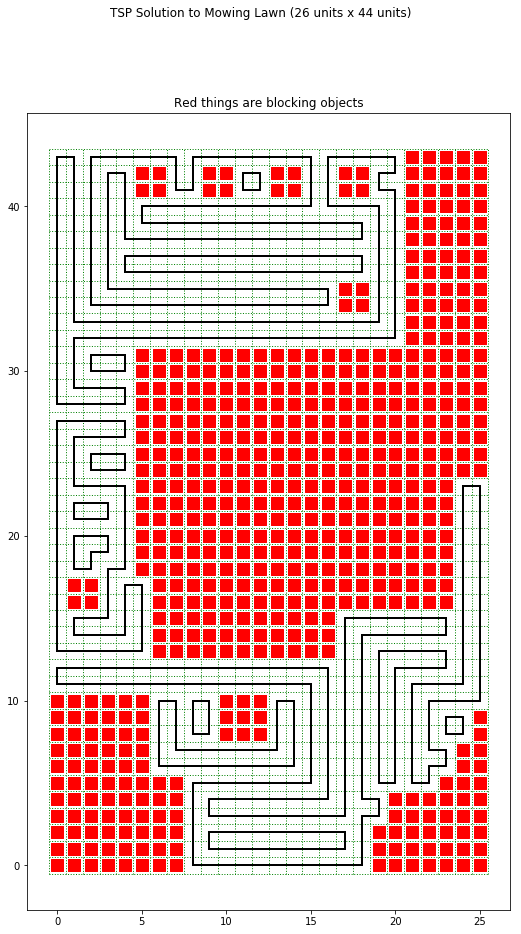

About to find cycles!
Cycle length:  124
Cycle length:  18
Cycle length:  24
Cycle length:  46
Cycle length:  30
Cycle length:  6
Cycle length:  4
Cycle length:  56
Cycle length:  8
Cycle length:  6
Cycle length:  6
Cycle length:  104
Cycle length:  6
Cycle length:  108
Cycle length:  30
Cycle length:  4
Optimize a model with 10586 rows, 5722 columns and 31940 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R10570 by 1.000000000

Presolve removed 1602 rows and 315 columns
Presolve time: 0.11s
Presolved: 8984 rows, 5407 columns, 28190 nonzeros
Variable types: 0 continuous, 5407 integer (5407 binary)
Found heuristic solution: objective 174.0000000

Root relaxation: objective 2.300000e+01, 2494 iterations, 0.18 seconds

    Nodes    

     0     0   98.24215    0 1790  152.00000   98.24215  35.4%     -   17s
     0     2   98.24215    0 1779  152.00000   98.24215  35.4%     -   18s
    84    84  105.22751   30 1646  152.00000   98.59435  35.1%   105   20s
H  207   207                     150.0000000   98.59435  34.3%   142   23s
   261   264  119.07767   92 1283  150.00000   98.59435  34.3%   146   25s
H  456   459                     142.0000000   98.59435  30.6%   136   28s
H  483   467                     140.0000000   98.59435  29.6%   133   29s
   515   497   99.45904    4 1848  140.00000   99.02360  29.3%   133   30s
H  596   548                     138.0000000   99.02360  28.2%   137   33s
   682   651  113.67108   73 1613  138.00000   99.02360  28.2%   133   35s
   752   714  108.68585   41 1592  138.00000   99.02360  28.2%   133   41s
   759   719  116.35359   76 1961  138.00000  106.76005  22.6%   132   45s
   765   723  122.07426   46 1977  138.00000  122.07426  11.5%   131   50s
   774   729  128.43550  

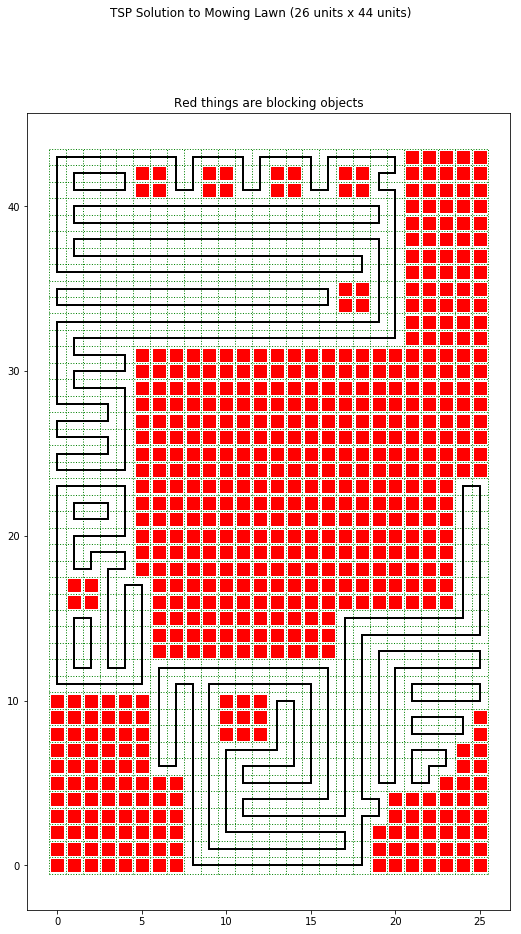

About to find cycles!
Cycle length:  124
Cycle length:  62
Cycle length:  28
Cycle length:  8
Cycle length:  8
Cycle length:  10
Cycle length:  54
Cycle length:  8
Cycle length:  6
Cycle length:  192
Cycle length:  34
Cycle length:  38
Cycle length:  8
Optimize a model with 10599 rows, 5722 columns and 32520 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R10586 by 1.000000000

Presolve removed 1602 rows and 314 columns
Presolve time: 0.09s
Presolved: 8997 rows, 5408 columns, 28715 nonzeros
Variable types: 0 continuous, 5408 integer (5408 binary)
Found heuristic solution: objective 202.0000000

Root relaxation: objective 2.300000e+01, 2512 iterations, 0.16 seconds

    Nodes    |    Current Node    |     Objective Bounds      |   

     0     0  102.59717    0 1899  186.00000  102.59717  44.8%     -   17s
     0     0  102.86926    0 1937  186.00000  102.86926  44.7%     -   17s
     0     0  102.99076    0 1932  186.00000  102.99076  44.6%     -   18s
     0     0  103.01471    0 1951  186.00000  103.01471  44.6%     -   18s
     0     0  103.42014    0 1918  186.00000  103.42014  44.4%     -   18s
     0     0  103.44662    0 1924  186.00000  103.44662  44.4%     -   18s
     0     0  103.89714    0 1935  186.00000  103.89714  44.1%     -   18s
     0     0  103.93738    0 1955  186.00000  103.93738  44.1%     -   18s
     0     0  103.94059    0 1921  186.00000  103.94059  44.1%     -   18s
     0     0  104.10604    0 1924  186.00000  104.10604  44.0%     -   19s
     0     0  104.10604    0 1893  186.00000  104.10604  44.0%     -   19s
     0     2  104.10604    0 1873  186.00000  104.10604  44.0%     -   20s
H   28    28                     182.0000000  104.33392  42.7%   179   21s
H  117   117             

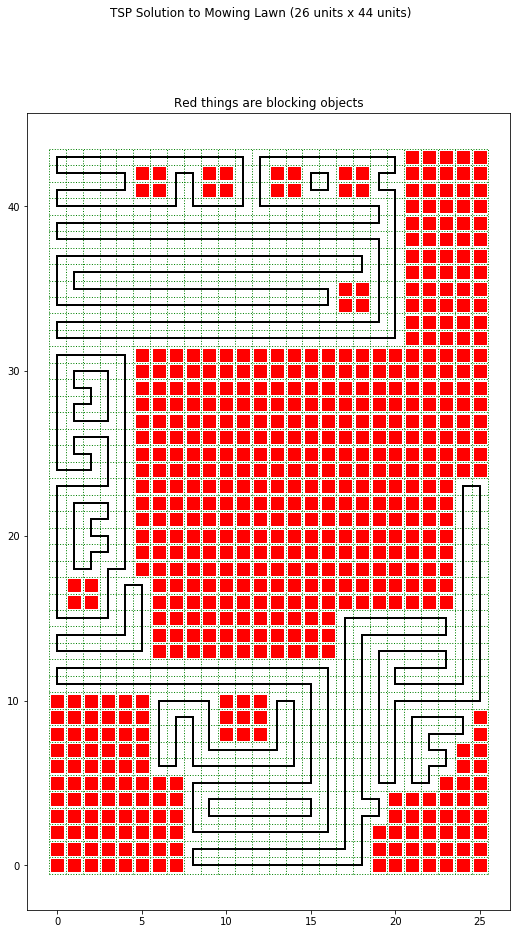

About to find cycles!
Cycle length:  62
Cycle length:  66
Cycle length:  14
Cycle length:  58
Cycle length:  16
Cycle length:  36
Cycle length:  18
Cycle length:  52
Cycle length:  14
Cycle length:  12
Cycle length:  116
Cycle length:  72
Cycle length:  40
Cycle length:  4
Optimize a model with 10613 rows, 5722 columns and 33100 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R10599 by 1.000000000

Presolve removed 1602 rows and 315 columns
Presolve time: 0.09s
Presolved: 9011 rows, 5407 columns, 29238 nonzeros
Variable types: 0 continuous, 5407 integer (5407 binary)
Found heuristic solution: objective 180.0000000

Root relaxation: objective 2.300000e+01, 2419 iterations, 0.16 seconds

    Nodes    |    Current Node    |     Objec

     0     0   99.87506    0 1914  162.00000   99.87506  38.3%     -   19s
     0     0   99.91678    0 1953  162.00000   99.91678  38.3%     -   19s
     0     0   99.92686    0 1939  162.00000   99.92686  38.3%     -   20s
     0     0  100.40883    0 1884  162.00000  100.40883  38.0%     -   20s
H    0     0                     160.0000000  100.40883  37.2%     -   20s
     0     0  100.54462    0 1865  160.00000  100.54462  37.2%     -   20s
     0     0  100.55350    0 1902  160.00000  100.55350  37.2%     -   20s
     0     0  101.27181    0 1879  160.00000  101.27181  36.7%     -   20s
     0     0  101.31535    0 1914  160.00000  101.31535  36.7%     -   21s
     0     0  101.32024    0 1917  160.00000  101.32024  36.7%     -   21s
     0     0  101.47152    0 1939  160.00000  101.47152  36.6%     -   21s
     0     0  101.47152    0 1876  160.00000  101.47152  36.6%     -   21s
     0     2  101.47152    0 1866  160.00000  101.47152  36.6%     -   23s
    28    28  104.10099  

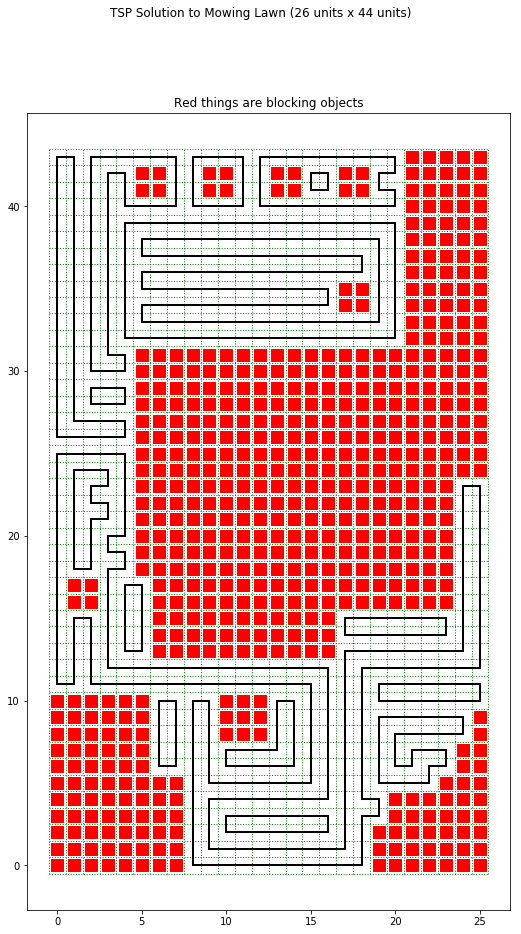

About to find cycles!
Cycle length:  196
Cycle length:  14
Cycle length:  26
Cycle length:  10
Cycle length:  16
Cycle length:  14
Cycle length:  10
Cycle length:  14
Cycle length:  18
Cycle length:  42
Cycle length:  6
Cycle length:  42
Cycle length:  46
Cycle length:  86
Cycle length:  12
Cycle length:  24
Cycle length:  4
Optimize a model with 10630 rows, 5722 columns and 33680 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R10613 by 1.000000000

Presolve removed 1602 rows and 314 columns
Presolve time: 0.12s
Presolved: 9028 rows, 5408 columns, 29764 nonzeros
Variable types: 0 continuous, 5408 integer (5408 binary)
Found heuristic solution: objective 210.0000000

Root relaxation: objective 2.300000e+01, 2412 iterations, 0.18 s

     0     0   99.96841    0 1915  192.00000   99.96841  47.9%     -   19s
     0     0  100.16268    0 1910  192.00000  100.16268  47.8%     -   20s
     0     0  100.27927    0 1947  192.00000  100.27927  47.8%     -   20s
     0     0  100.29424    0 1954  192.00000  100.29424  47.8%     -   20s
     0     0  100.47191    0 1891  192.00000  100.47191  47.7%     -   20s
     0     0  100.50095    0 1963  192.00000  100.50095  47.7%     -   20s
     0     0  100.72845    0 1889  192.00000  100.72845  47.5%     -   21s
     0     0  100.72845    0 1807  192.00000  100.72845  47.5%     -   21s
     0     2  100.72845    0 1780  192.00000  100.72845  47.5%     -   22s
H   28    28                     188.0000000  101.04614  46.3%   157   23s
H   85    87                     186.0000000  101.04614  45.7%   115   24s
    97    99  109.26391   33 1590  186.00000  101.04614  45.7%   122   25s
H  206   207                     180.0000000  101.04614  43.9%   122   28s
   283   284  128.19585  

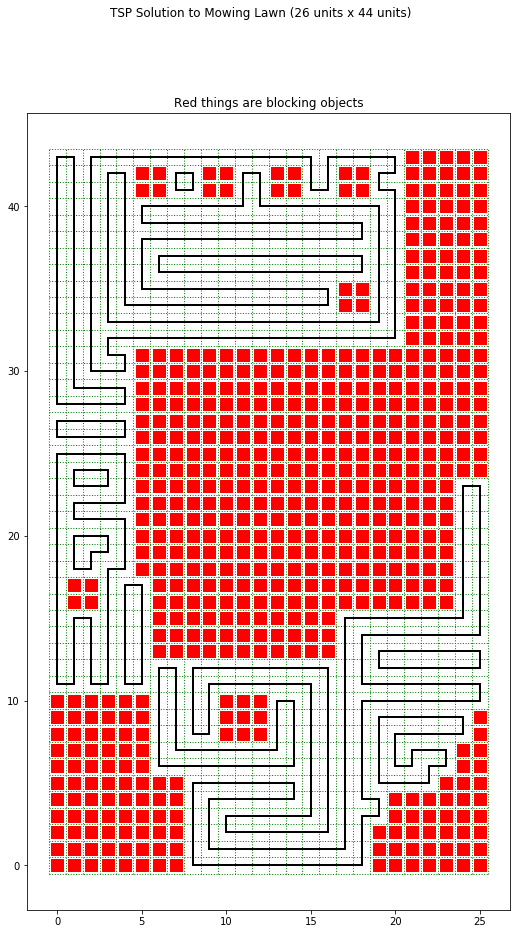

About to find cycles!
Cycle length:  114
Cycle length:  52
Cycle length:  26
Cycle length:  34
Cycle length:  50
Cycle length:  14
Cycle length:  14
Cycle length:  8
Cycle length:  6
Cycle length:  10
Cycle length:  38
Cycle length:  70
Cycle length:  114
Cycle length:  26
Cycle length:  4
Optimize a model with 10645 rows, 5722 columns and 34260 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R10630 by 1.000000000

Presolve removed 1602 rows and 315 columns
Presolve time: 0.16s
Presolved: 9043 rows, 5407 columns, 30287 nonzeros
Variable types: 0 continuous, 5407 integer (5407 binary)
Found heuristic solution: objective 206.0000000

Root relaxation: objective 2.300000e+01, 2470 iterations, 0.19 seconds

    Nodes    |    Current No

     0     0  103.40580    0 1867  186.00000  103.40580  44.4%     -   18s
     0     0  103.41169    0 1860  186.00000  103.41169  44.4%     -   18s
     0     0  103.83147    0 1871  186.00000  103.83147  44.2%     -   19s
     0     0  103.87678    0 1910  186.00000  103.87678  44.2%     -   19s
     0     0  103.88571    0 1922  186.00000  103.88571  44.1%     -   19s
     0     0  104.16000    0 1923  186.00000  104.16000  44.0%     -   19s
     0     0  104.25463    0 1906  186.00000  104.25463  43.9%     -   20s
     0     0  104.27618    0 1913  186.00000  104.27618  43.9%     -   20s
     0     0  104.72627    0 1946  186.00000  104.72627  43.7%     -   20s
     0     0  104.81234    0 1908  186.00000  104.81234  43.6%     -   20s
     0     0  104.81721    0 1947  186.00000  104.81721  43.6%     -   20s
     0     0  104.92516    0 1949  186.00000  104.92516  43.6%     -   20s
     0     0  104.92516    0 1912  186.00000  104.92516  43.6%     -   21s
     0     2  104.92516  

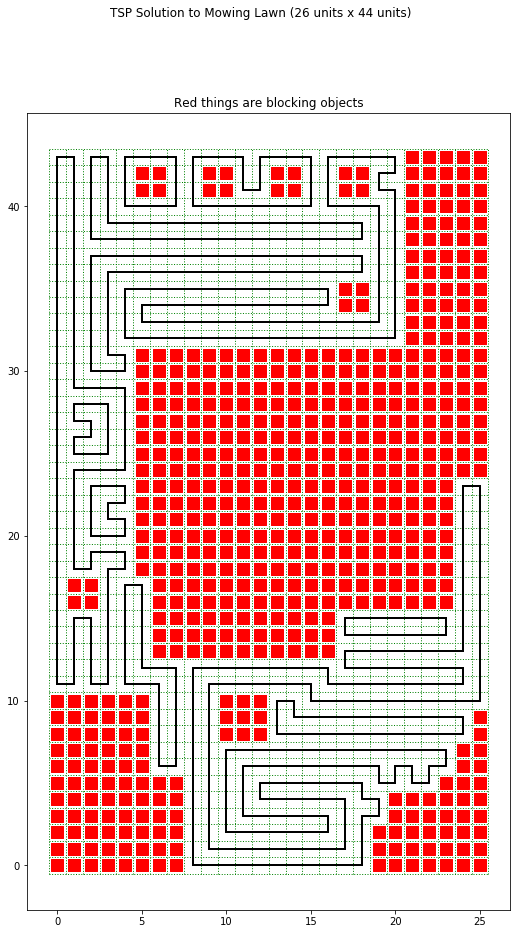

About to find cycles!
Cycle length:  136
Cycle length:  50
Cycle length:  28
Cycle length:  26
Cycle length:  88
Cycle length:  14
Cycle length:  12
Cycle length:  12
Cycle length:  48
Cycle length:  88
Cycle length:  42
Cycle length:  12
Cycle length:  24
Optimize a model with 10658 rows, 5722 columns and 34840 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R10645 by 1.000000000

Presolve removed 1602 rows and 315 columns
Presolve time: 0.11s
Presolved: 9056 rows, 5407 columns, 30812 nonzeros
Variable types: 0 continuous, 5407 integer (5407 binary)
Found heuristic solution: objective 188.0000000

Root relaxation: objective 2.300000e+01, 2351 iterations, 0.17 seconds

    Nodes    |    Current Node    |     Objective Bounds      

     0     0  101.68609    0 1920  168.00000  101.68609  39.5%     -   20s
     0     0  101.74848    0 1862  168.00000  101.74848  39.4%     -   20s
     0     0  101.74848    0 1811  168.00000  101.74848  39.4%     -   20s
     0     2  101.74848    0 1811  168.00000  101.74848  39.4%     -   22s
    83    84  106.99993   30 1639  168.00000  101.94848  39.3%   165   25s
H  141   139                     164.0000000  101.94848  37.8%   154   26s
H  259   258                     156.0000000  101.94848  34.6%   124   29s
   287   285  134.02302  108  906  156.00000  101.94848  34.6%   119   30s
H  378   361                     148.0000000  101.94848  31.1%   105   31s
H  424   420                     142.0000000  101.94848  28.2%   101   31s
H  491   446                     140.0000000  101.96730  27.2%   102   33s
   534   489  107.38914   30 1773  140.00000  101.96730  27.2%   108   35s
   657   610  120.30090   76 1545  140.00000  101.96730  27.2%   116   40s
   739   692  109.37997  

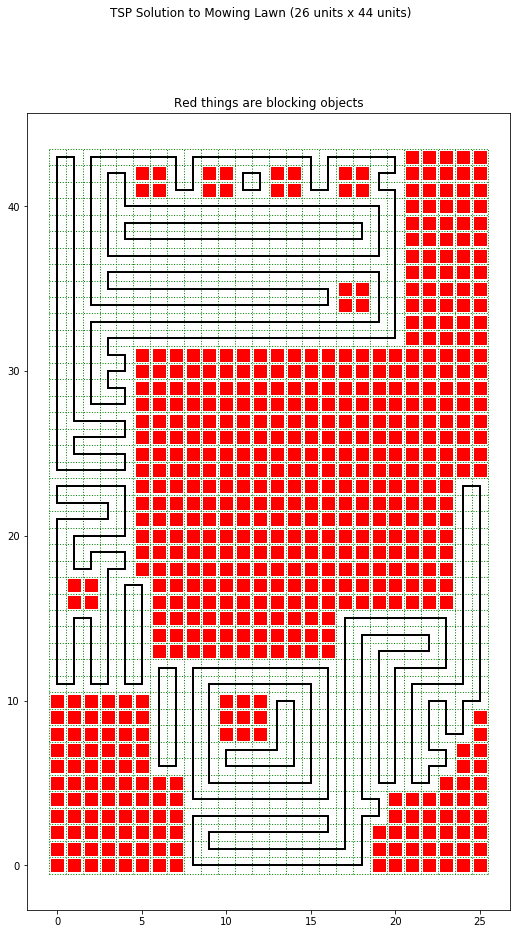

About to find cycles!
Cycle length:  104
Cycle length:  32
Cycle length:  24
Cycle length:  50
Cycle length:  14
Cycle length:  16
Cycle length:  54
Cycle length:  14
Cycle length:  52
Cycle length:  144
Cycle length:  42
Cycle length:  30
Cycle length:  4
Optimize a model with 10671 rows, 5722 columns and 35420 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R10658 by 1.000000000

Presolve removed 1603 rows and 314 columns
Presolve time: 0.16s
Presolved: 9068 rows, 5408 columns, 31336 nonzeros
Variable types: 0 continuous, 5408 integer (5408 binary)
Found heuristic solution: objective 184.0000000

Root relaxation: objective 2.300000e+01, 2547 iterations, 0.21 seconds

    Nodes    |    Current Node    |     Objective Bounds      

     0     0  100.28520    0 1932  172.00000  100.28520  41.7%     -   21s
     0     0  100.36479    0 1959  172.00000  100.36479  41.6%     -   21s
     0     0  100.37456    0 1976  172.00000  100.37456  41.6%     -   21s
     0     0  101.25660    0 1922  172.00000  101.25660  41.1%     -   22s
     0     0  101.39983    0 1847  172.00000  101.39983  41.0%     -   22s
     0     0  101.49957    0 1958  172.00000  101.49957  41.0%     -   22s
     0     0  101.51796    0 1952  172.00000  101.51796  41.0%     -   22s
     0     0  101.97800    0 1927  172.00000  101.97800  40.7%     -   22s
H    0     0                     170.0000000  101.97800  40.0%     -   23s
     0     0  102.08286    0 1942  170.00000  102.08286  40.0%     -   23s
     0     0  102.13659    0 1951  170.00000  102.13659  39.9%     -   23s
     0     0  102.14280    0 1941  170.00000  102.14280  39.9%     -   23s
     0     0  102.45488    0 1919  170.00000  102.45488  39.7%     -   23s
     0     0  102.56816  

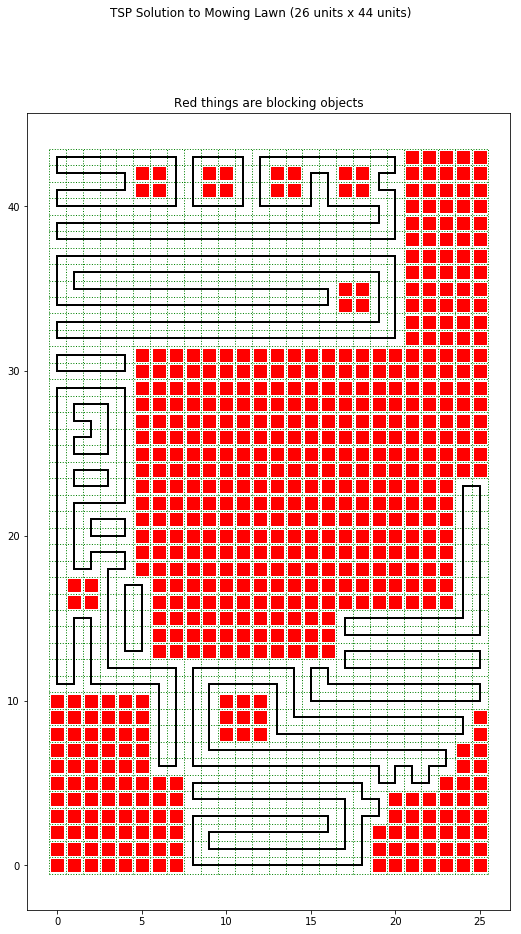

About to find cycles!
Cycle length:  68
Cycle length:  82
Cycle length:  78
Cycle length:  24
Cycle length:  18
Cycle length:  10
Cycle length:  34
Cycle length:  6
Cycle length:  6
Cycle length:  12
Cycle length:  10
Cycle length:  122
Cycle length:  70
Cycle length:  28
Cycle length:  12
Optimize a model with 10686 rows, 5722 columns and 36000 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R10671 by 1.000000000

Presolve removed 1602 rows and 315 columns
Presolve time: 0.31s
Presolved: 9084 rows, 5407 columns, 31859 nonzeros
Variable types: 0 continuous, 5407 integer (5407 binary)
Found heuristic solution: objective 190.0000000

Root relaxation: objective 2.300000e+01, 2461 iterations, 0.47 seconds

    Nodes    |    Current No

In [ ]:
m.optimize()
plot_tsp_solution(flat_tiles, location_edges, row_count=len(tiles), col_count=len(tiles[0]))

while True:
    shortest_cycle, cycle_count, cycles = find_cycles(location_edges)
    if cycle_count <= 2:
        print('Solved!')
        plot_tsp_solution(flat_tiles, location_edges, row_count=len(tiles), col_count=len(tiles[0]))
        break
    else:
        for cycle in cycles:
            m.addConstr(sum([location_edges[to_loc(edge)] for edge in cycle]) <= len(cycle)-1)
        m.optimize()
        plot_tsp_solution(flat_tiles, location_edges, row_count=len(tiles), col_count=len(tiles[0]))

In [ ]:
plot_tsp_solution(flat_tiles, location_edges, row_count=len(tiles), col_count=len(tiles[0]))